## FAST特征点提取算法

##### 特征点
1. 角点：周围发生颜色明显变化的那些地方  
2. 描述子(周围信息)：把周围的像素通过一系列计算方式变成一个数字。用于前后两帧图片中相同特征点匹配  

##### 所有特征提取与匹配算法通用过程
1. 找到那些周围有明显变化的像素点作为特征点。  
2. 提取这些特征点周围信息。一般在当前点周围随机采样几个像素点作为当前特征点的周围信息，或者画个圈圈进行采样。不同采样方法构成了不同算法。  
3. 特征点匹配。比如跟踪某个物体，先从这个物体提取一些特征点，然后看下一帧相同特征点的位置在哪。

### FAST特征点提取算法 (Features from Accelerated Segment Test)
遍历所有的像素点，判断其是否为特征点：
    在以当前像素点为圆心以3像素为半径画个圆（圆上有16个点），统计这16个点的像素值与圆心像素值相差超过阈值的点的个数。
    超过9个差异度很大的点那就认为圆心那个像素点是一个特征点。

![在这里插入图片描述](https://img-blog.csdnimg.cn/20190718160218250.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3ZhcnlzaGFyZQ==,size_16,color_FFFFFF,t_70)  

### Bresenham 布雷森汉姆算法画圆的原理 


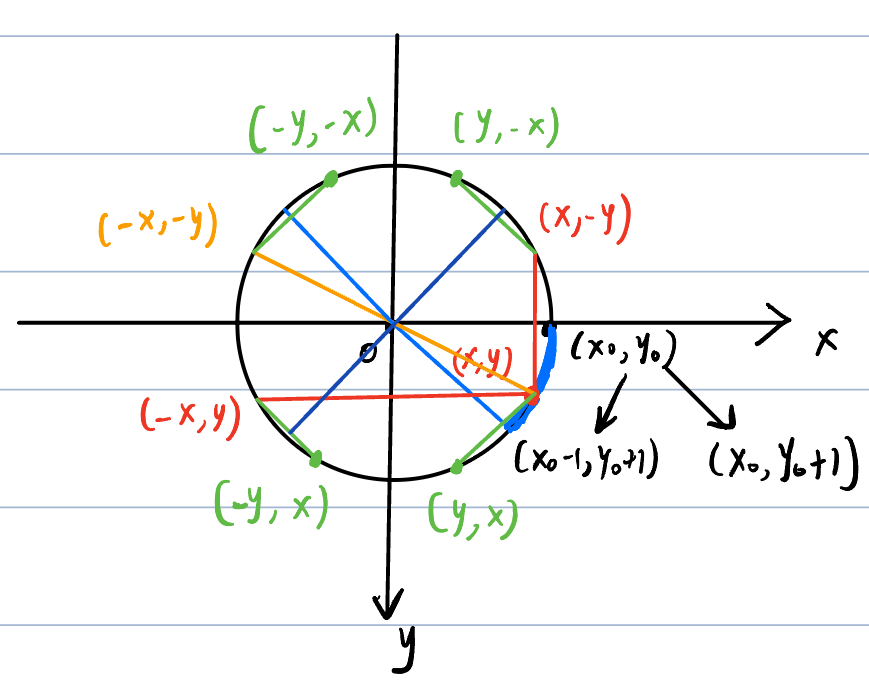  
只用确定八分之一的圆弧，即可通过对称性画出整个圆。
如图，假设该圆弧上一次所选点为$(x_k,y_k)$，则下一步可能为$(x_k-1,y_k+1)$为$(x_k,y_k+1)$。前一个点一定在圆弧内，后一个则在圆弧外，我们需要选取离圆弧最近的那个点。  
  
两点到圆弧距离的平方分别为:  
$d1 = (x_k-1)^2+(y_k+1)^2-r^2$  
$d2 = (x_k)^2+(y_k+1)^2-r^2$  
  
定义$P_k = d1+d2$用以比较两者距离大小：  
若$P_k>=0$, 选第一个点$(x_k-1,y_k+1)$（因为另一个点偏离圆弧程度更大）  
若$P_k<0$, 则选第二个点$(x_k,y_k+1)$

为了加快计算，求出了递推公式：   
当$P_k>=0$时，$P_{k+1}=P_k-4x_k+4y_k+10$  
当$P_k<0$时，$P_{k+1}=P_k+4y_k+6$  

注意：根据初始点为(r,0)来计算$P_k$的初始值=$-2r+3$。

### Bresenham 画圆法实现

In [1]:
import numpy as np
import matplotlib.pyplot as plt
img = np.zeros((105, 105)) # 创建一个105x105的画布

In [2]:
def draw(x, y, img):
    '''绘制点'''
    # 平移原点：将原理图中的笛卡尔坐标系转换为图形学坐标系
    # 将画布的左上角移到原点位置
    x += int(img.shape[0]/2)
    y += int(img.shape[1]/2)

    img[-y, x] = 1 # 注意y轴正方向变为向下

r_pixel = 50 # 圆的半径, 单位：像素

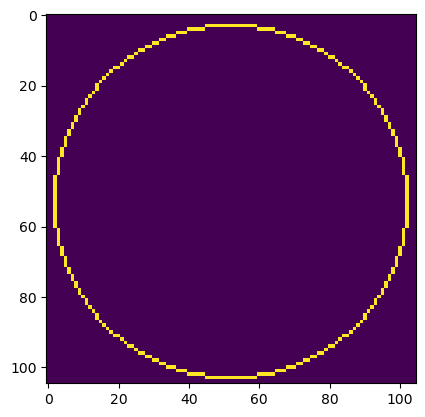

In [3]:
# 初始化第一个点(第一个点的Pk=-2r+3)
(x,y) = (r_pixel,0)
P_k = -2*r_pixel + 3
while x>=y:
    draw(x, y, img)
    draw(-x, y, img)
    draw(x, -y, img)
    draw(-x, -y, img)
    draw(y, x, img)
    draw(y, -x, img)
    draw(-y, x, img)
    draw(-y, -x, img)
    if P_k >= 0:
        p_k_next = P_k - 4*x + 4*y + 10
        (x_next, y_next) = (x-1, y+1)
    else:
        p_k_next = P_k + 4*y + 6
        (x_next, y_next) = (x, y+1)
    (x, y) = (x_next, y_next)
    P_k = p_k_next

plt.imshow(img)

### FAST特征点检测算法

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # 用于读取图片

In [5]:
# 1. 读取图片
img = cv2.imread('feature.png',cv2.IMREAD_GRAYSCALE)

# 2. 设置参数
# 设置灰度值差异阈值，高差异点数阈值
h_gray_scale = 20 # 在ORB特征提取中使用的FAST像素差阈值默认是20
k_diff_point = 9 # 超过k_diff_point个差异那就认为是关键点（周围共16个点）
r_pixel = 3 # 获取周围像素所用的圆的半径,单位：像素

# 3. 遍历所有的像素进行检测关键点

# 创建圆周掩码
def bresenham():
    """
    return: 3*3 圆周上所有的点相对圆心的坐标列表。
    """
    _masked_canvas = np.zeros((2*r_pixel + 1, 2*r_pixel + 1))
    def save(x, y):
        '''把(x,y)加入到结果列表中'''
        _masked_canvas[-y+r_pixel, x+r_pixel] = 1
    
    (x,y) = (r_pixel,0)
    P_k = -2*r_pixel + 3
    while x>=y:
        save(x, y)
        save(-x, y)
        save(x, -y)
        save(-x, -y)
        save(y, x)
        save(y, -x)
        save(-y, x)
        save(-y, -x)
        if P_k >= 0:
            p_k_next = P_k - 4*x + 4*y + 10
            (x_next, y_next) = (x-1, y+1)
        else:
            p_k_next = P_k + 4*y + 6
            (x_next, y_next) = (x, y+1)
        (x, y) = (x_next, y_next)
        P_k = p_k_next

    return _masked_canvas

masked_canvas = bresenham()

In [ ]:
# 逐个搜索关键点
def key_point_test(_row, _col):
    '''
    检测像素点(_row,_col)是否是关键点。
    '''
    # 获取以(_row,_col)为几何中心的7x7正方形区域内的像素值
    surround_points = img[_row-3:_row+3+1, _col-3:_col+3+1]
    # 获取圆周上的点与圆心的像素差值的绝对值
    _dist = np.abs((surround_points - img[_row,_col])) * masked_canvas
    if (_dist>h_gray_scale).sum()> k_diff_point:
        return True
    else:
        return False

key_point_list = []

for row in range(r_pixel,img.shape[0]-r_pixel):
    for col in range(r_pixel,img.shape[1]-r_pixel):
        
        if key_point_test(row,col):
            # ! 注意添加的是cv2.KeyPoint对象
            key_point_list.append(cv2.KeyPoint(x=row, y=col, size=1))
        else:
            continue
    pass
pass

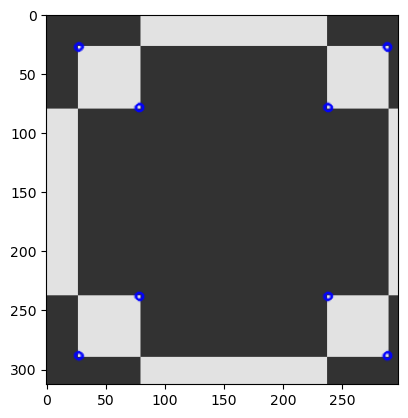

In [8]:
img_with_keypoints = cv2.drawKeypoints(
    img,
    key_point_list, # ! 注意必须是cv2.KeyPoint对象列表
    outImage=np.array([]), # 提供了一个空数组。OpenCV 会自动创建一个新的图像数组来存储结果。
    color=(0,0,255)
)
# cv2.imshow("show key points",img_with_keypoints)
# cv2.waitKey(0)
plt.imshow(img_with_keypoints)

### 使用OpenCV实现ORB特征点提取  
Oriented FAST and Rotated BRIEF(描述子) 

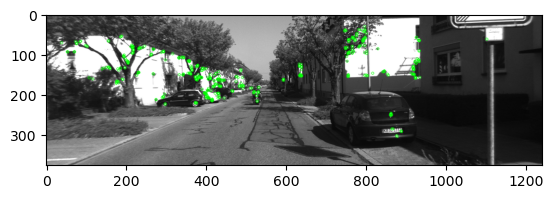

In [12]:
import cv2
import numpy as np
# 0. 读取图片
img = cv2.imread('./right.png',cv2.IMREAD_GRAYSCALE)
# 1. 创建一个ORB检测器实例
orb = cv2.ORB_create()
# 2. 检测关键点
keypoint, descript = orb.detectAndCompute(img,None)
# 3. 绘制关键点
result_img = cv2.drawKeypoints(img,keypoint,None,color=(0,255,0),flags=cv2.IMREAD_GRAYSCALE)
# 4. 显示含有关键点的图片
# cv2.imshow("ORB feature point extract",result_img)
# cv2.waitKey(0)
plt.imshow(result_img)